In `Comapre intermediate results -- 2` and `Comapre intermediate results -- 3` I established that the time embeddings on local / cloud is equal.

But why are they shown as different in my overview?

**Answer:** The time embedding (ie pre-projection) is equal up to `1e-4`. My overview shows the time projection, has errors of ~ `1e-1`. The projection operation has "matrix norm" ~1200, so it is expected that the error increases ~3 orders of magnitude.

So this is a pureliy numerical issue.

In [1]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [3]:
from diffusers import StableDiffusionXLPipeline
from diffusers import EulerDiscreteScheduler
from diffusers.models.controlnetxs import ControlNetXSModel
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [4]:
sdxl_pipe = StableDiffusionXLPipeline.from_single_file('weights/sdxl/sd_xl_base_1.0_0.9vae.safetensors').to(device)
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs').to(device)

At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [5]:
cnxs.base_model = sdxl_pipe.unet

The example script of Heidelberg manually sets scale_list to 0.95

In [6]:
cnxs.scale_list = cnxs.scale_list * 0. + 0.95
assert cnxs.scale_list[0] == .95

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [7]:
scheduler_cgf = dict(sdxl_pipe.scheduler.config)
scheduler_cgf['timestep_spacing'] = 'linspace'
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

# test it worked
sdxl_pipe.scheduler.set_timesteps(50)
assert sdxl_pipe.scheduler.timesteps[0]==999

# reset
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...
timestep_spacing = "leading" and timesteps=[999.      978.61224 958.2245  937.83673 917.449  ] ...
sigmas before interpolation: [0.02916753 0.04131448 0.05068044 0.05861427 0.06563709] ...
sigmas after (linear) interpolation: [14.61464691 12.93677721 11.49164976 10.24291444  9.16035419] ...
At end of `set_timesteps`:
sigmas =  tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604]) ...
timesteps = tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490]) ...
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [8]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

___

## Re-confirm the time embs before projection are identical

In [9]:
from util import print_shapes
from util_plot import visually_compare_1d

def equal(x,y,atol=1e-4): return allclose(x.cpu(),y.cpu(),atol=atol)

Load cloud additional time embeds

In [10]:
infos = ('txt','orig_sz','crop','tgt_sz')
splits = (1280, 512, 512, 512)

In [11]:
c_vector = torch.load('intermediate_output/temb/cloud/c_vector', map_location='cpu')
uc_vector = torch.load('intermediate_output/temb/cloud/uc_vector', map_location='cpu')

emb_cloud_uc = dict(zip(infos, torch.split(uc_vector[0], splits, dim=0)))
emb_cloud_c = dict(zip(infos, torch.split(c_vector[0], splits, dim=0)))

print_shapes(*emb_cloud_uc.values())
print_shapes(*emb_cloud_c.values())

[1280], [512], [512], [512]
[1280], [512], [512], [512]


Load local additional time embeds

In [12]:
emb_l_add_embeds = torch.load('intermediate_output/temb/local/add_embeds', map_location='cpu')

emb_local_uc = dict(zip(infos, torch.split(emb_l_add_embeds[0], splits, dim=0)))
emb_local_c = dict(zip(infos, torch.split(emb_l_add_embeds[1], splits, dim=0)))

print_shapes(*emb_local_uc.values())
print_shapes(*emb_local_c.values())

[1280], [512], [512], [512]
[1280], [512], [512], [512]


In [13]:
for i in infos:
    assert equal(emb_cloud_uc[i], emb_local_uc[i], atol=1e-2)
    assert equal(emb_cloud_c[i],  emb_local_c[i], atol=1e-2)

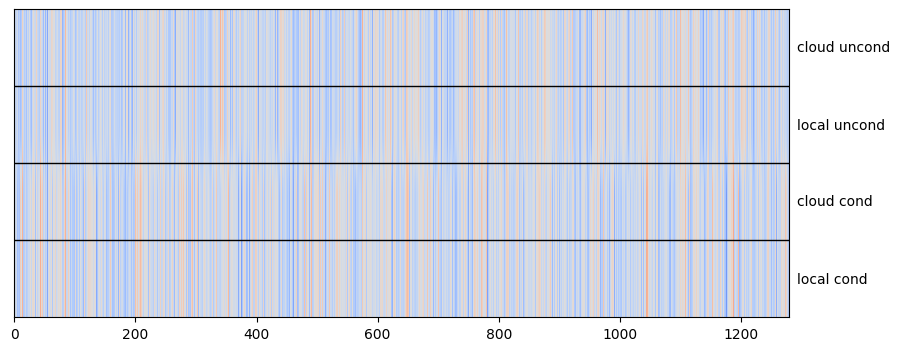

In [14]:
visually_compare_1d(
    (emb_cloud_uc['txt'], emb_local_uc['txt'],emb_cloud_c['txt'], emb_local_c['txt']),
    ('cloud uncond', 'local uncond','cloud cond', 'local cond')
)

## Load intermediate outputs of full model

In [15]:
from util_inspect import load_intermediate_outputs, print_metadata, compare_intermediate_results

In [16]:
model_outp_cloud = load_intermediate_outputs('intermediate_output/cloud_debug_log.pkl')
model_outp_local = load_intermediate_outputs('intermediate_output/local_debug_log.pkl')
len(model_outp_cloud),len(model_outp_local)

(72, 72)

In [17]:
model_outp_cloud[1].shape, model_outp_local[1].shape

([2, 1280], [2, 1280])

In [18]:
temb_cloud_uc, temb_cloud_c = model_outp_cloud[1].t
temb_local_uc, temb_local_c = model_outp_local[1].t
print_shapes(temb_cloud_uc, temb_cloud_c, temb_local_uc, temb_local_c)

[1280], [1280], [1280], [1280]


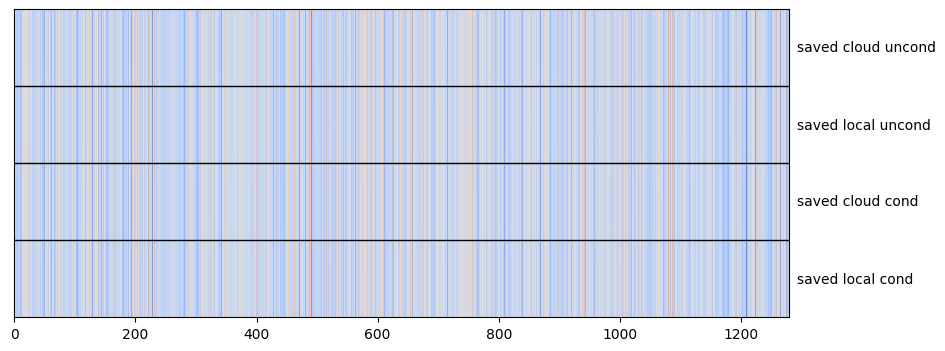

In [19]:
visually_compare_1d(
    (
        temb_cloud_uc,temb_local_uc,
        temb_cloud_c,temb_local_c,
    ),
    (
        'saved cloud uncond', 'saved local uncond',
        'saved cloud cond', 'saved local cond',
    )
)

**This can't be.**

I expected:
- Condtional and unconditional embeddings to be different, as their text part is different
- Local and cloud to be different, as that's what my overview shows

In [20]:
equal(temb_local_c, temb_local_uc, atol=1e-2), equal(temb_local_c, temb_local_uc, atol=1e-1)

(False, False)

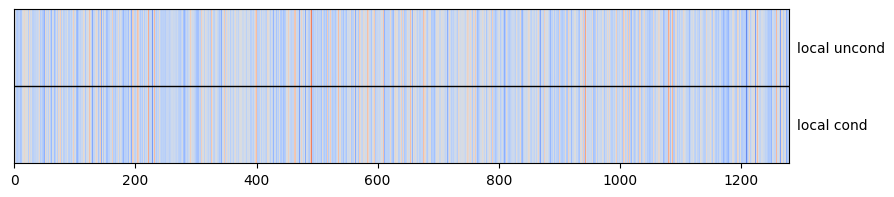

In [21]:
visually_compare_1d((temb_local_uc, temb_local_c), ('local uncond', 'local cond'))

They **are** different, but visually appear equal

In [22]:
temb_local_uc[:10], temb_local_c[:10]

(tensor([ 1.4959, -3.6011,  1.8189, -1.6592, -1.5132, -2.1749, -1.6586, -1.7922,  0.0885, -2.2889]),
 tensor([ 1.3859, -3.5991,  1.8941, -1.6574, -1.5342, -2.2058, -1.7063, -1.7391,  0.0161, -2.2524]))

I would have expected `temb_local_uc` and `temb_local_c` to be very different

Same for cloud versions:

In [23]:
temb_cloud_uc[:10], temb_cloud_c[:10]

(tensor([ 1.5199, -3.6599,  1.8496, -1.6871, -1.5362, -2.2114, -1.6819, -1.8184,  0.0893, -2.3246]),
 tensor([ 1.4099, -3.6581,  1.9248, -1.6852, -1.5572, -2.2422, -1.7296, -1.7654,  0.0171, -2.2881]))

**Let's check I fully understand how temb is created by reproducing it**

So let's reproduce `temb_local_uc` and `temb_local_c`.

Remember: `temb = temb + self.base_model.add_embedding(add_embeds)`, where `temb` is the pure time embedding

In [24]:
t = tensor([999.])
t

tensor([999.])

In [25]:
from diffusers.models.embeddings import get_timestep_embedding

In [26]:
temb_pure_time_1 = get_timestep_embedding(t, 320, flip_sin_to_cos=True, downscale_freq_shift=0)
temb_pure_time_1.shape

torch.Size([1, 320])

In [27]:
temb_pure_time_1[0,:10]

tensor([ 0.9996,  0.8027, -0.2781,  0.1768, -0.2780,  0.1252, -0.9289, -0.0870, -0.4233, -0.2622])

Because `learn_embedding=True`, we use a combindation of control's and base's time projection (weighting determined by `cnxs.config.control_scale`)

In [28]:
cnxs.config.control_scale

0.95

In [29]:
time_projection_ctrl = cnxs.control_model.time_embedding
time_projection_base = cnxs.base_model.time_embedding

print(time_projection_ctrl)
print(time_projection_base)

TimestepEmbedding(
  (linear_1): Linear(in_features=320, out_features=1280, bias=True)
  (act): SiLU()
  (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
)
TimestepEmbedding(
  (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
  (act): SiLU()
  (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
)


**Q:** The `in_features`, ie the time emb has shape 320, but on cloud it is 256!

**A:** No, the `in_features` are the dimension of the timestep embedding. The timestep embedding for (i) time and (ii) additional info (orig size, crop, target size) are different. They're `320` and `256` respectively.

Here's how the timestep embedding for time is computed on cloud: `t_emb = timestep_embedding(timesteps, self.model_channels, repeat_only=False)` with `self.model_channels=320`

In [30]:
def apply_time_projection(temb, alpha): return time_projection_ctrl(temb) * alpha**0.3 + time_projection_base(temb) * (1-alpha**0.3)

In [31]:
temb_pure_time_2 = apply_time_projection(temb_pure_time_1.to(device), 0.95).cpu().detach()
temb_pure_time_2.shape

torch.Size([1, 1280])

In [32]:
temb_pure_time_2[:10]

tensor([[ 1.3571, -3.6848,  1.9868,  ..., -0.7487, -1.2921, -1.4140]])

Now, let's project the additional time info

In [33]:
add_time_projection = cnxs.base_model.add_embedding
add_time_projection

TimestepEmbedding(
  (linear_1): LoRACompatibleLinear(in_features=2816, out_features=1280, bias=True)
  (act): SiLU()
  (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
)

In [34]:
emb_l_add_embeds.shape

torch.Size([2, 2816])

In [35]:
temb_only_additional = add_time_projection(emb_l_add_embeds.to(device)).cpu().detach()
temb_only_additional.shape

torch.Size([2, 1280])

In [36]:
temb_final = temb_pure_time_2 + temb_only_additional
temb_final.shape

torch.Size([2, 1280])

In [37]:
temb_local_uc_reproduced, temb_local_c_reproduced = temb_final
print_shapes(temb_local_uc_reproduced, temb_local_c_reproduced)

[1280], [1280]


In [38]:
equal(temb_local_uc_reproduced,temb_local_uc,atol=1e-5), equal(temb_local_c_reproduced,temb_local_c,atol=1e-4)

(True, True)

Okay, I can reproduce `temb_local_uc`/`temb_local_c` (ie the time emb used in the denoiser) from the timestep (`999`) and the `emb_l_add_embeds` (ie the concat of `txt` and time embs of `orig sz`/`crop`/`tgt sz`).

___

**Q: Let's continue investigating why temb_local_uc, temb_local_c are so similar**

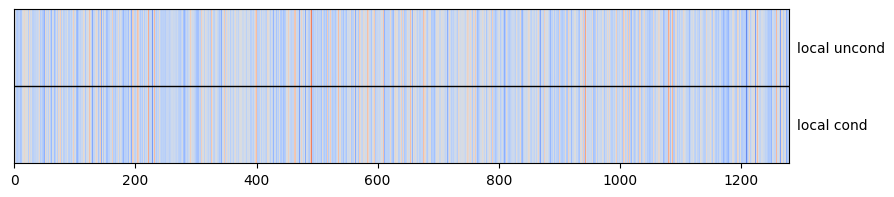

In [39]:
visually_compare_1d((temb_local_uc, temb_local_c), ('local uncond', 'local cond'))

In [40]:
equal(temb_local_c, temb_local_uc, atol=1e-1)

False

**Hypothesis:** The time part (which is equal for cond/uncond) dominates

Test: Is standard deviation of time part larger than for additional time (ie txt/orig sz/crop/tgt size) part?

`temb_final = temb_pure_time_2 + temb_only_additional`

In [41]:
temb_only_additional[0].std(), temb_only_additional[1].std()

(tensor(0.1581), tensor(0.1540))

In [42]:
temb_pure_time_2[0].std()

tensor(1.9205)

**A:** The uncond/cond time embs are different, but the time part (which is identical) strongly dominates. That's why they seem visually equal.

Just out of curiosity: What's the mean?

In [43]:
temb_only_additional[0].mean(), temb_only_additional[1].mean(), temb_pure_time_2[0].mean()

(tensor(0.0216), tensor(0.0094), tensor(-0.7452))

___

**Q:** Why are the time emds on local and cloud so different?

In [44]:
compare_intermediate_results(model_outp_cloud, model_outp_local, n=5, prec=5, compare_prec=3)

-  | cloud               | local               | equal name? | equal shape? | equal values? | mean abs Δ
   |                     |                     |             |              |    prec=3     |     prec=5
--------------------------------------------------------------------------------------------------------
0  | prep   x            | prep   x            |      y      |      y       |       y       |    0.00000
1  | prep   temb         | prep   temb         |      y      |      y       |       n       |    0.02456
2  | prep   context      | prep   context      |      y      |      y       |       n       |    0.00053
3  | prep   raw hint     | prep   raw hint     |      y      |      y       |       y       |    0.00000
4  | prep   guided_hint  | prep   guided_hint  |      y      |      y       |       n       |    0.00009


In [45]:
temb_c, temb_l = model_outp_cloud[1].t, model_outp_local[1].t
print_shapes(temb_c, temb_l)

[2, 1280], [2, 1280]


In [46]:
temb_c[0,:10], temb_l[0,:10]

(tensor([ 1.5199, -3.6599,  1.8496, -1.6871, -1.5362, -2.2114, -1.6819, -1.8184,  0.0893, -2.3246]),
 tensor([ 1.4959, -3.6011,  1.8189, -1.6592, -1.5132, -2.1749, -1.6586, -1.7922,  0.0885, -2.2889]))

They seem almost equal (up to ~ `0.04`, which is `2*std(additionl time emb)`), so I hypothesize the difference comes from the additional time emb part

No, already the pure time projection is different.

Cloud temb:
```
A (pure time emb) : tensor([ 0.9996,  0.8027, -0.2781,  0.1768, -0.2780,  0.1252, -0.9289, -0.0870, -0.4233, -0.2622])
B (pure time proj): tensor([ 1.3810, -3.7437,  2.0176, -1.7097, -1.5402, -2.2996, -1.7285, -1.7810, -0.1062, -2.3676])
C (text emb)      : tensor([-0.5938, -0.3401, -0.4072,  0.5571, -1.0176,  0.1389,  0.2322, -1.2148, -0.7808, -0.1032])
D (other emb)     : tensor([ 0.1191, -0.0330,  0.5759, -1.0000, -0.5341, -0.2881, -0.7052,  0.6554, -0.0907,  0.9736])
E (add emb)       : tensor([-0.5938, -0.3401, -0.4072,  0.5571, -1.0176,  0.1389,  0.2322, -1.2148, -0.7808, -0.1032])
F (add proj)      : tensor([ 0.1388,  0.0838, -0.1679,  0.0226,  0.0040,  0.0882,  0.0466, -0.0375,  0.1956,  0.0430])
G (final time emb): tensor([ 1.5199, -3.6599,  1.8496, -1.6871, -1.5362, -2.2114, -1.6819, -1.8184,  0.0893, -2.3246])
```
Local temb:
```
A (pure time emb) : tensor([ 0.9996,  0.8027, -0.2781,  0.1767, -0.2780,  0.1253, -0.9289, -0.0870, -0.4232, -0.2622])
B (pure time proj): tensor([ 1.3571, -3.6848,  1.9868, -1.6818, -1.5172, -2.2632, -1.7052, -1.7547, -0.1071, -2.3319])
C (text emb)      : tensor([-0.5941, -0.3394, -0.4070,  0.5561, -1.0181,  0.1388,  0.2324, -1.2147, -0.7827, -0.1039])
D (other emb)     : tensor([ 0.1191, -0.0331,  0.5759, -1.0000, -0.5342, -0.2881, -0.7051,  0.6554, -0.0908,  0.9736])
E (add emb)       : tensor([-0.5941, -0.3394, -0.4070,  0.5561, -1.0181,  0.1388,  0.2324, -1.2147, -0.7827, -0.1039])
F (add proj)      : tensor([ 0.1388,  0.0838, -0.1680,  0.0226,  0.0039,  0.0882,  0.0466, -0.0375,  0.1956,  0.0430])
G (final time emb): tensor([ 1.4959, -3.6011,  1.8189, -1.6592, -1.5132, -2.1749, -1.6586, -1.7922,  0.0885, -2.2889])
```

To determine if the discrepancy is only due to `pure time projection` or also due to other projections, let's pass cloud intermediate outputs through local projections.

In [47]:
# Clout Temb Intermediate outputs
cti = {s:torch.load(f'intermediate_output/temb/cloud/temb_{s}',map_location='cpu') for s in 'ABCDEFG'}

In [48]:
local_projections = {
    'time_proj': lambda t: cnxs.control_model.time_embedding(t)*0.95**0.3 + cnxs.base_model.time_embedding(t)*(1-0.95**0.3),
    'add_proj': cnxs.base_model.add_embedding
}

We already know that `time_proj` produces slighty different results on local and cloud. What about `add_proj`?

In [49]:
add_emb_c = cti['E']
add_emb_l = emb_l_add_embeds

In [50]:
equal(add_emb_c, add_emb_l, atol=1e-2), equal(add_emb_c, add_emb_l, atol=1e-3)

(True, False)

In [51]:
add_proj_c_reproduced = local_projections['add_proj'](add_emb_c.to(device)).cpu().detach()
add_proj_c = cti['F']
add_proj_l = local_projections['add_proj'](add_emb_l.to(device)).cpu().detach()

In [52]:
equal(add_proj_c_reproduced, add_proj_c, atol=1e-7), equal(add_proj_c_reproduced, add_proj_l, atol=1e-3), equal(add_proj_c, add_proj_l, atol=1e-3)

(True, True, True)

When given the same input, `add_proj` produces exactly the same output on local and cloud.

Okay, then let's **compare the time projection matrices**

In [68]:
from itertools import product as it_prod
time_proj_params_local = {
    'base': {
        'linear_1': {
            'weight': cnxs.base_model.time_embedding.linear_1.weight.cpu().detach(),
            'bias':   cnxs.base_model.time_embedding.linear_1.bias.cpu().detach()
        },
        'linear_2': {
            'weight': cnxs.base_model.time_embedding.linear_2.weight.cpu().detach(),
            'bias':   cnxs.base_model.time_embedding.linear_2.bias.cpu().detach()
        }
    },
    'ctrl': {
        'linear_1': {
            'weight': cnxs.control_model.time_embedding.linear_1.weight.cpu().detach(),
            'bias':   cnxs.control_model.time_embedding.linear_1.bias.cpu().detach()
        },
        'linear_2': {
            'weight': cnxs.control_model.time_embedding.linear_2.weight.cpu().detach(),
            'bias':   cnxs.control_model.time_embedding.linear_2.bias.cpu().detach()
        }
    }
}

In [69]:
time_proj_params_cloud = time_proj_params_local.copy()

for m,l,wb in it_prod(('base','ctrl'), ('linear_1','linear_2'), ('weight','bias')): time_proj_params_cloud[m][l][wb] = None

time_proj_params_cloud

{'base': {'linear_1': {'weight': None, 'bias': None},
  'linear_2': {'weight': None, 'bias': None}},
 'ctrl': {'linear_1': {'weight': None, 'bias': None},
  'linear_2': {'weight': None, 'bias': None}}}

In [70]:
for m,l,wb in it_prod(('base','ctrl'), ('linear_1','linear_2'), ('weight','bias')):
    time_proj_params_cloud[m][l][wb] = torch.load(f'intermediate_output/temb/cloud/{m}-{l}-{wb}.pt')

In [71]:
for m,l,wb in it_prod(('base','ctrl'), ('linear_1','linear_2'), ('weight','bias')):
    print(m,l,wb,':',(time_proj_params_cloud[m][l][wb] == time_proj_params_local[m][l][wb]).all())

base linear_1 weight : tensor(True)
base linear_1 bias : tensor(True)
base linear_2 weight : tensor(True)
base linear_2 bias : tensor(True)
ctrl linear_1 weight : tensor(True)
ctrl linear_1 bias : tensor(True)
ctrl linear_2 weight : tensor(True)
ctrl linear_2 bias : tensor(True)


**Projection matrices are exactly equal**

In [75]:
t_emb_cloud = torch.load('intermediate_output/temb/cloud/temb_A',map_location='cpu')
t_proj_cloud = torch.load('intermediate_output/temb/cloud/temb_B',map_location='cpu')

t_emb_local = temb_pure_time_1
t_proj_local = temb_pure_time_2

In [88]:
equal(t_emb_cloud,t_emb_local,atol=1e-4)

True

In [92]:
equal(t_proj_cloud,t_proj_local,atol=1e-1)

False

In [94]:
(t_proj_cloud-t_proj_local).abs().max()

tensor(0.1028)

So:
1. `t_emb` has error <= `1-e4`
2. the exact same operation is applied (all params are exactly equal)
3. `t_proj` has error > `1e-1`

It seeme the operation applied to get from `t_emb` to `t_proj` has poor numerical stability

Let's check the **condition numbers**

In [96]:
def condition_number(A):
    u, s, v = torch.svd(A)
    return s[0] / s[-1]

In [97]:
condition_number(time_proj_params_cloud['base']['linear_1']['weight'])

tensor(41.8085)

In [105]:
import numpy as np
kappa_np = np.linalg.cond(time_proj_params_cloud['base']['linear_1']['weight'].numpy())
print(f'(Sanity check: Condition number of base/linear_1/weight computed with numpy is {kappa_np})')

(Sanity check: Condition number of base/linear_1/weight computed with numpy is 41.80854415893555)


In [108]:
print('Condition numbers:')
for m,l in it_prod(('ctrl','base'),('linear_1','linear_2')):
    kappa = condition_number(time_proj_params_cloud[m][l]['weight'])
    print(f'- {m}/{l}: {kappa:.2f}')

Condition numbers:
- ctrl/linear_1: 11.02
- ctrl/linear_2: 27409.46
- base/linear_1: 41.81
- base/linear_2: 15005.64


The condition number of the operation `t_emb` -> `t_proj` is order `10,000`. Therefore it is expected for errors to explode.

**No!** The condition number is for solving a linear system (ie `y = Ax`, how does error in `y` propagate to `x`; the operation is `inv(A)`), but we're doing a linear transformation. The operation is `A` itself.

In [123]:
print('Matrix norms (Frobenius):')
for m,l in it_prod(('ctrl','base'),('linear_1','linear_2')):
    matnorm = torch.linalg.matrix_norm(time_proj_params_cloud[m][l]['weight'], ord='fro')
    print(f'- {m}/{l}: {matnorm:.2f}')

Matrix norms (Frobenius):
- ctrl/linear_1: 21.07
- ctrl/linear_2: 32.72
- base/linear_1: 13.61
- base/linear_2: 11.19


I'm always looking at the mean absolute error, ie the l1-error. So I need to look at the l1-matrix norm as well.

In [124]:
print('Matrix norms (L1):')
for m,l in it_prod(('ctrl','base'),('linear_1','linear_2')):
    matnorm = torch.linalg.matrix_norm(time_proj_params_cloud[m][l]['weight'], ord=1)
    print(f'- {m}/{l}: {matnorm:.2f}')

Matrix norms (L1):
- ctrl/linear_1: 39.88
- ctrl/linear_2: 33.49
- base/linear_1: 29.87
- base/linear_2: 16.04


Remember, the projection operation is

- `t_proj = linear_interpolate(ctrl_proj(t_emb), base_proj(t_emb), 0.95**3)`
- `ctrl_proj = linear_2(silu(linear_1(t_emb)))`
- similar for `base_proj`

Ignoring the sili, the "matrix norm" of the entire operation is:

In [127]:
(39.88*33.49)*(0.95**3)+(29.87*16.04)*(1-0.95**3)

1213.4276796999998

**Solution:** So, we should expect the error to increase 3-4 orders is magnitude, which is exaclty what's happening.